In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, ReLU, Add,
    Flatten, Reshape, Activation
)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np

def load_dataset(M, K, T):
    Path_Beta_mk = "D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\Beta_mk_46712.csv"
    Path_Eitta_mk = "D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\Eitta_mk_46712.csv"
    
    #  Load data with proper headers
    Beta_mk_T = pd.read_csv(Path_Beta_mk, header=None)
    Eitta_mk_T = pd.read_csv(Path_Eitta_mk, header=None)
    
    # Convert to numpy arrays
    Beta_mk = Beta_mk_T.values.reshape(-1, M, K)
    Eitta_mk = Eitta_mk_T.values.reshape(-1, M, K)
    
    # Verify shapes match expected dimensions
    assert Beta_mk.shape == (T, M, K), f"Beta shape mismatch. Got {Beta_mk.shape}, expected ({T}, {M}, {K})"
    print('beta',Beta_mk[0])
    print('eitta',Eitta_mk[0] )
    Beta_mk = Beta_mk[:46700, :, :]
    Eitta_mk = Eitta_mk[:46700, :, :]
    return Beta_mk, Eitta_mk
    print('done 1') 

try:
    Beta_mk, Eitta_mk = load_dataset(25, 6, 46712)
    print("Data loaded successfully!")
    print(f"Beta shape: {Beta_mk.shape}")
    
except Exception as e:
    print(f"Error loading data: {str(e)}")

beta [[1.3746e-12 3.1890e-13 1.9067e-11 2.0927e-13 1.9702e-11 1.9743e-12]
 [3.6860e-12 4.2611e-12 2.2992e-13 3.5445e-13 9.2836e-13 3.7511e-14]
 [1.0794e-13 2.9828e-12 2.9534e-11 7.4219e-12 2.5497e-13 2.8652e-11]
 [5.2190e-13 1.1525e-12 6.3168e-14 7.1137e-12 1.7431e-12 1.0413e-12]
 [8.7048e-13 5.5596e-11 9.4864e-12 2.8862e-10 5.1377e-12 1.0013e-11]
 [4.0378e-12 8.5596e-10 2.7995e-13 8.4624e-13 7.5794e-11 2.5716e-11]
 [4.4740e-12 5.6059e-12 1.6370e-11 1.8363e-11 7.5067e-12 5.0240e-11]
 [1.5237e-10 2.8011e-11 6.9495e-12 3.0225e-14 5.0080e-10 4.8415e-13]
 [9.3515e-14 5.2760e-12 1.1555e-11 2.5286e-12 1.2032e-12 4.4434e-10]
 [1.1912e-09 2.0344e-12 2.8214e-13 5.0570e-14 7.8402e-11 5.7973e-13]
 [8.4382e-13 5.9336e-11 1.0693e-12 1.3480e-11 1.7067e-12 7.5650e-11]
 [1.5603e-11 9.4915e-13 7.7206e-12 2.3820e-13 2.7861e-13 8.0955e-12]
 [5.2319e-13 1.0177e-12 8.6122e-13 3.3798e-11 7.5900e-12 1.1478e-09]
 [3.2365e-12 9.5536e-13 1.7410e-11 7.3023e-10 9.8710e-13 8.5005e-11]
 [8.9573e-12 1.5905e-10 5.394

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D,Conv1D, BatchNormalization, ReLU, Add,
    GlobalAveragePooling2D, Dense, Reshape, Activation,Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Multiply, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2

def se_block(x, ratio=16):
    channels = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    return Multiply()([x, se])

def resnet_block(x, filters, kernel_size=(5, 5), name=None):
    """Residual block with proper Sum connection"""
    shortcut = x
    
    # Main path
    x = Conv2D(filters, kernel_size, padding='same', name=f'{name}_conv1')(x)
    x = BatchNormalization(name=f'{name}_bn1')(x)
    x = ReLU(name=f'{name}_relu1')(x)
    
    x = Conv2D(filters, kernel_size, padding='same', name=f'{name}_conv2')(x)
    x = BatchNormalization(name=f'{name}_bn2')(x)
    
    # Shortcut connection
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), name=f'{name}_shortcut')(shortcut)
        shortcut = BatchNormalization(name=f'{name}_shortcut_bn')(shortcut)
    
    x = Add(name=f'{name}_sum')([x, shortcut])
    x = ReLU(name=f'{name}_out')(x)
    return x

def build_joint_PC_model(input_shape, M, K, P,RESNET_BLOCKS , NO_Filters):  
    inputs = Input(shape=input_shape, name='LSF_Input')  # (25, 1, 6)
    # Conv Block 1
    x = Conv2D(NO_Filters, (5, 5), padding='same', name='conv_block1')(inputs)
    x = BatchNormalization(momentum=0.99, name='bn1')(x)
    x = ReLU(name='relu1')(x)
    
    # ResNet Blocks (R=3)
    for i in range(RESNET_BLOCKS):
        x = resnet_block(x, NO_Filters, name=f'resnet{i+1}')

    x = se_block(x, ratio=16)  # Add SE block
    # Conv Block 2
    x = Conv2D(NO_Filters, (5, 5), padding='same', name='conv_block2',kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization(momentum=0.99, name='bn2')(x)
    x = ReLU(name='relu2')(x)
    x = Dropout(0.4)(x)

    # ======== Power Control Branch ========
    pc = Conv2D(K, (5, 5), padding='same', name='power_conv',kernel_regularizer=l2(1e-4))(x)
    pc = Reshape((M, K), name='power_output_1')(pc)
    pc = Activation('linear',name='power_output' )(pc)

    return Model(inputs=inputs, outputs=[ pc])
# Parameters
M, K, P = 25, 6, 2  # APs, Users, Pilots
RESNET_BLOCKS =3
NO_Filters = 256
input_shape = (M, 1, K)  # Height, Width, Channels
EPOCHS = 100
BATCH_SIZE = 128
# ==============================================
# Model Compilation
# ==============================================
PC_model_4 = build_joint_PC_model(input_shape, M, K, P ,RESNET_BLOCKS,NO_Filters)

PC_model_4.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=3e-4,
        beta_1=0.99  # Adam's first momentum parameter
    ),
    loss={'power_output': tf.keras.losses.Huber(delta=0.1) #Mean Squared Logarithmic Error (MSLE) 
       # 'pilot_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'power_output': ['mae'],
        #'pilot_output': ['accuracy']
    }
)

print("\nModel Output Names:", PC_model_4.output_names)
print("Model Output Shapes:", [output.shape for output in PC_model_4.outputs])

print(PC_model_4.output_names)
print([output.shape for output in PC_model_4.outputs])
PC_model_4.summary()



Model Output Names: ListWrapper(['power_output'])
Model Output Shapes: [(None, 25, 6)]
ListWrapper(['power_output'])
[(None, 25, 6)]


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ LSF_Input (InputLayer)        │ (None, 25, 1, 6)          │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv_block1 (Conv2D)          │ (None, 25, 1, 256)        │          38,656 │ LSF_Input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn1 (BatchNormalization)      │ (None, 25, 1, 256)        │           1,024 │ conv_block1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ relu1 (ReLU)                  │ (None, 25, 1, 256)        │               0 │ bn1[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet1_conv1 (Conv2D)        │ (None, 25, 1, 256)        │       1,638,656 │ relu1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet1_bn1                   │ (None, 25, 1, 256)        │           1,024 │ resnet1_conv1[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet1_relu1 (ReLU)          │ (None, 25, 1, 256)        │               0 │ resnet1_bn1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet1_conv2 (Conv2D)        │ (None, 25, 1, 256)        │       1,638,656 │ resnet1_relu1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet1_bn2                   │ (None, 25, 1, 256)        │           1,024 │ resnet1_conv2[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet1_sum (Add)             │ (None, 25, 1, 256)        │               0 │ resnet1_bn2[0][0],         │
│                               │                           │                 │ relu1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet1_out (ReLU)            │ (None, 25, 1, 256)        │               0 │ resnet1_sum[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet2_conv1 (Conv2D)        │ (None, 25, 1, 256)        │       1,638,656 │ resnet1_out[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet2_bn1                   │ (None, 25, 1, 256)        │           1,024 │ resnet2_conv1[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet2_relu1 (ReLU)          │ (None, 25, 1, 256)        │               0 │ resnet2_bn1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resnet2_conv2 (Conv2D)        │ (None, 25, 1, 256)        │       1,638,656 │ resnet2_relu1[0][0]        │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 11,564,310 (44.11 MB)

 Trainable params: 11,560,214 (44.10 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, Add,
    GlobalAveragePooling2D, Dense, Reshape, Activation)
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import joblib

# Train/validation split
# Split both X and y together
#X_train, X_val, ypc_train, ypc_val = train_test_split(
#    Beta_mk, 
#    Eitta_mk, 
#    test_size=0.2, 
#    random_state=42
#    shuffle=True
#)
split_idx = int(0.8 * 46700)
X_train, X_val = Beta_mk[:split_idx], Beta_mk[split_idx:]
ypc_train, ypc_val = Eitta_mk[:split_idx], Eitta_mk[split_idx:]   

print('xshape' , X_train.shape)
print('yshape',ypc_train.shape)
# Inputs (Beta_mk)
scaler_X_2 = MinMaxScaler()
X_train= np.where(X_train <= 0, 1e-30, X_train)
X_train_log = np.log(X_train)
X_train_normalized = scaler_X_2.fit_transform(X_train_log.reshape(-1, K))
X_train_normalized = X_train_normalized.reshape(-1, M, 1, K)  # (samples, M, 1, K)

X_val= np.where(X_val <= 0, 1e-30, X_val)
X_val_log = np.log(X_val)
X_val_normalized = scaler_X_2.transform(X_val_log.reshape(-1, K))
X_val_normalized = X_val_normalized.reshape(-1, M, 1, K)

# Targets (Eitta_mk)
scaler_y_2 = MinMaxScaler()
# For training targets
ypc_train_scaled = scaler_y_2.fit_transform(ypc_train.reshape(-1, K))
ypc_train_scaled = ypc_train_scaled.reshape(-1, M, K)  # Remove ", 1"
ypc_train_scaled= np.where(ypc_train_scaled <= 0, 1e-30, ypc_train_scaled)
ypc_train_scaled = np.log(ypc_train_scaled)

# For validation targets
ypc_val_scaled = scaler_y_2.transform(ypc_val.reshape(-1, K))
ypc_val_scaled = ypc_val_scaled.reshape(-1, M, K)  
ypc_val_scaled= np.where(ypc_val_scaled <= 0, 1e-30, ypc_val_scaled)
ypc_val_scaled = np.log(ypc_val_scaled)

print('beta',X_train[0])
print('betanorm',X_train_normalized[0])
print('eitta',ypc_train[0])
print('eitta_scaled',ypc_train_scaled[0])

# ==============================================
# Training Configuration
# ==============================================
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',  # Stops based on MSE
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'PC_model_4.keras', 
        save_best_only=True,
        monitor='val_mae'  # Saves best model based on MSE
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mae',  # Reduces LR based on MAE
        factor=0.2,
        patience=15,
        verbose=1
    ),
    tf.keras.callbacks.TerminateOnNaN()
]

print('we will train the model now , be ready')
print(PC_model_4.output_shape)
joblib.dump(scaler_X_2, 'minmax_x.save')
joblib.dump(scaler_y_2, 'minmax_y.save')
# Assuming:
# - X_train_normalized: Preprocessed training inputs (shape: (samples, 25, 1, 6))
# - ypc_train_scaled: Scaled training targets (shape: (samples, 25, 6))
# - X_val_normalized: Preprocessed validation inputs
# - ypc_val_scaled: Scaled validation targets

history = PC_model_4.fit(
    X_train_normalized,  # Training inputs
    ypc_train_scaled,    # Training targets
    validation_data=(X_val_normalized, ypc_val_scaled),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)
PC_model_4.save(f'PC_model_4.keras')
print('trained ^ ^')


xshape (37360, 25, 6)
yshape (37360, 25, 6)
beta [[1.3746e-12 3.1890e-13 1.9067e-11 2.0927e-13 1.9702e-11 1.9743e-12]
 [3.6860e-12 4.2611e-12 2.2992e-13 3.5445e-13 9.2836e-13 3.7511e-14]
 [1.0794e-13 2.9828e-12 2.9534e-11 7.4219e-12 2.5497e-13 2.8652e-11]
 [5.2190e-13 1.1525e-12 6.3168e-14 7.1137e-12 1.7431e-12 1.0413e-12]
 [8.7048e-13 5.5596e-11 9.4864e-12 2.8862e-10 5.1377e-12 1.0013e-11]
 [4.0378e-12 8.5596e-10 2.7995e-13 8.4624e-13 7.5794e-11 2.5716e-11]
 [4.4740e-12 5.6059e-12 1.6370e-11 1.8363e-11 7.5067e-12 5.0240e-11]
 [1.5237e-10 2.8011e-11 6.9495e-12 3.0225e-14 5.0080e-10 4.8415e-13]
 [9.3515e-14 5.2760e-12 1.1555e-11 2.5286e-12 1.2032e-12 4.4434e-10]
 [1.1912e-09 2.0344e-12 2.8214e-13 5.0570e-14 7.8402e-11 5.7973e-13]
 [8.4382e-13 5.9336e-11 1.0693e-12 1.3480e-11 1.7067e-12 7.5650e-11]
 [1.5603e-11 9.4915e-13 7.7206e-12 2.3820e-13 2.7861e-13 8.0955e-12]
 [5.2319e-13 1.0177e-12 8.6122e-13 3.3798e-11 7.5900e-12 1.1478e-09]
 [3.2365e-12 9.5536e-13 1.7410e-11 7.3023e-10 9.8710e-

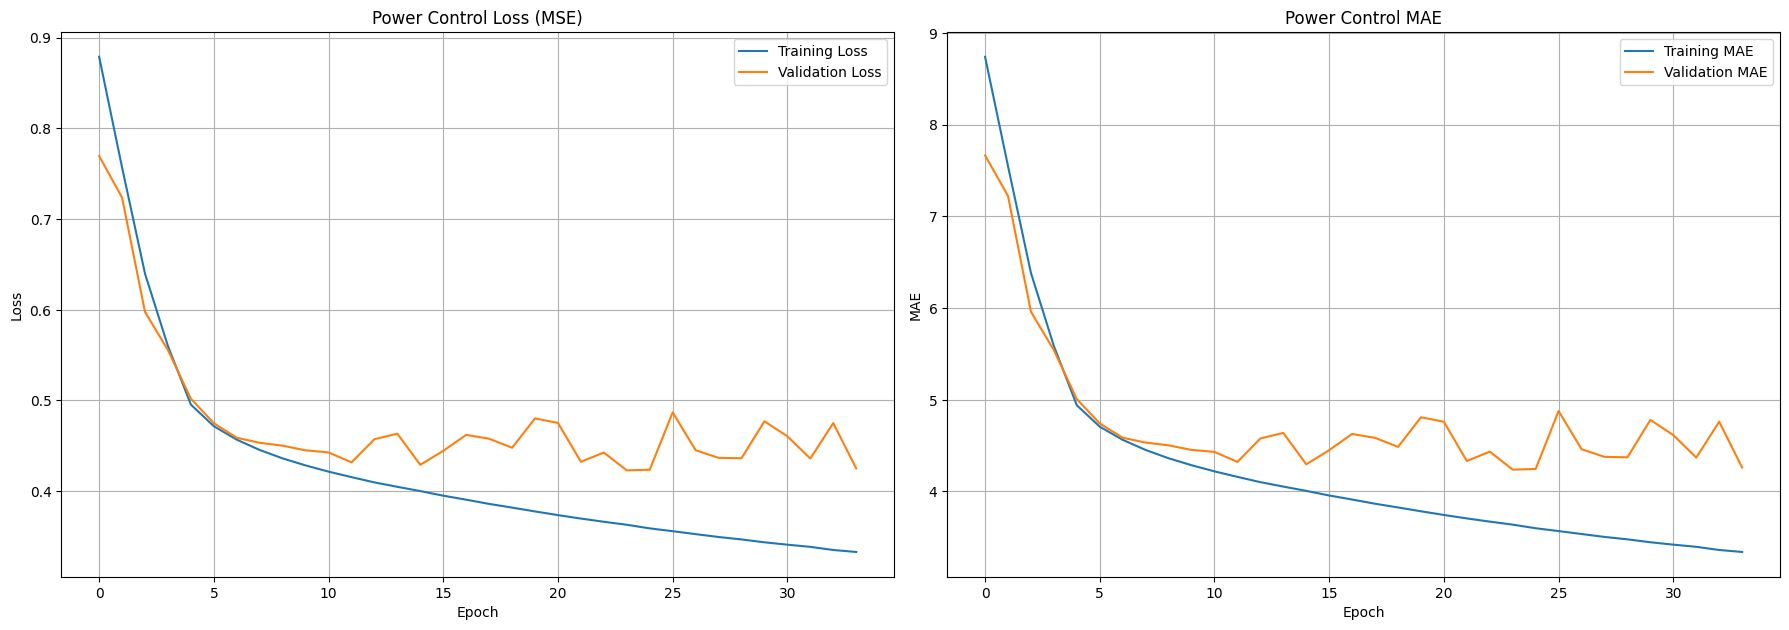

In [4]:
import matplotlib.pyplot as plt

# Plotting configuration
plt.figure(figsize=(18, 12))

# ======================
# Power Control Metrics
# ======================
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Power Control Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Power Control MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, ReLU, Add,
    Flatten, Reshape, Activation
)
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import joblib

# 1. Load Required Components
PC_model_4 = tf.keras.models.load_model('PC_model_4.keras')
scaler_X_2 = joblib.load('minmax_x.save')  # Assuming you saved during training
scaler_y_2 = joblib.load('minmax_y.save') 

def batch_predict(raw_betas):  # raw_betas shape: (N, 25, 6)
    # Reshape to (N*M, K) for scaling
    #beta_normalized = raw_betas #scaler_X.transform(raw_betas.reshape(-1, K))
    raw_betas= np.where(raw_betas <= 0, 1e-30, raw_betas)
    beta_log = np.log(raw_betas)
    beta_normalized = scaler_X_2.transform(beta_log.reshape(-1, K))
    # Reshape to (N, M, 1, K) for model input
    beta_normalized = beta_normalized.reshape(-1, M, 1, K)  # ← Dynamic batch size
    pc_norm = PC_model_4.predict(beta_normalized)
    
    print('pcnorm' , pc_norm)
    ypc_pred_scaled = np.exp(pc_norm)
    # 2. Inverse the Scaling
    ypc_pred_original = scaler_y_2.inverse_transform(ypc_pred_scaled.reshape(-1, K))
    return ypc_pred_original.reshape(-1, M, K)  # Return shape: (N, 25, 6)

# Define M and K (APs and Users)
M, K = 25, 6  # Update if different in your case

# Raw beta values (replace with your actual data)
Path_Beta_predict = r"D:\OneDrive - Assuit University\My_files\Master Material\Papers\P5_Joint_Powercontrol_PilotAssignement\Beta_test_148.csv"

# Load data with proper headers
Beta_mk_T_Predict = pd.read_csv(Path_Beta_predict, header=None)
# Convert to numpy arrays
new_beta = Beta_mk_T_Predict.values.reshape(-1, M, K)
#Beta_mk_T_Predict = X_train[0]
# Convert to numpy arrays
#new_beta = Beta_mk_T_Predict.reshape(-1, M, K)

print("new_beta:", new_beta)

# Get predictions
pc_output = batch_predict(new_beta)

#pc_coefficients_mod_400_log = pc_coefficients_mod_400_log.reshape(6,25)
#print("\nPower Control Coefficients (Original Scale):")
print(pc_output.shape)

#print("Min/Max of denormalized power:", pc_output.min(), pc_output.max())

new_beta: [[[8.1472e-13 5.9061e-13 1.0963e-11 3.0604e-13 7.3695e-12 6.1269e-13]
  [6.5715e-13 2.7445e-13 1.0863e-10 1.2746e-11 7.7498e-13 2.2691e-12]
  [3.0834e-11 2.6362e-12 3.3526e-13 4.8279e-10 2.6932e-13 2.4880e-12]
  ...
  [7.8926e-10 2.1216e-12 1.0603e-12 3.1631e-13 6.8418e-13 1.0286e-11]
  [1.6685e-13 3.2931e-11 5.5240e-11 4.0107e-12 7.3723e-10 5.4029e-13]
  [5.5355e-12 3.8091e-12 8.0516e-11 1.1470e-12 1.3876e-13 7.3608e-11]]

 [[1.7601e-10 3.7048e-12 1.6734e-12 1.0334e-12 1.0841e-11 6.7458e-13]
  [9.0647e-13 2.3758e-12 2.7722e-10 9.2830e-13 2.8157e-12 4.0683e-11]
  [3.3047e-10 3.6105e-12 3.7565e-12 1.8749e-12 2.6993e-10 2.3841e-12]
  ...
  [1.6989e-10 5.4792e-13 5.2623e-12 1.3165e-09 1.0979e-13 1.6989e-12]
  [4.4486e-13 3.1456e-11 4.4247e-13 2.5760e-13 4.0584e-12 1.6504e-12]
  [6.0385e-11 3.7130e-12 5.4883e-13 4.4683e-12 1.8226e-12 1.8258e-13]]

 [[3.3173e-10 4.5835e-13 2.3202e-14 1.7143e-12 1.1356e-10 3.9470e-10]
  [1.2549e-12 9.4237e-13 2.1821e-12 5.7823e-12 5.7626e-12 4.3567

In [2]:
import scipy.io
import numpy as np

# Wrap the array in a dictionary with a MATLAB variable name (e.g., "pc_coefficients")
data_dict = {'pc_output_148': pc_output}

# Save the dictionary to .mat file
scipy.io.savemat('pc_output_148.mat', data_dict)